In [2]:
# JRA55 netcdf
import datetime
from dateutil import tz
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.constants as m_const
from metpy.units import units
import numpy as np
import xarray as xr
import scipy.ndimage as ndimage
import scipy.constants as s_const
import sys
import math

In [2]:
## 読み込みデータの指定
# JRA55の読み込む年月日時をUTCで与えます。
i_year =1961
i_month = 7
i_day = 15
i_hourZ = 18
# 気圧面を指定
i_pre=300
# データ切り出し領域
lat_cut=slice(80.0,-20.0)
lon_cut=slice(70.0,190.0)
#
# データ格納先フォルダー名
# !!!　　UGRD_yyyymm.nc  などの保存先
DataFd="./data/Jra55/"
#
## 描画指定
# 地図の描画範囲指定
i_area = [115, 151, 20, 50]  # 日本付近
# 緯線・経線の指定
dlon,dlat=10,10   # 10度ごとに
## 発散のハッチの指定
levels_reld = [-10, -5, -2, -1, 1, 2, 5, 10]
## ISOTAC 等値線
levels_ws =np.arange(40,300,20)
# 等高度線 等値線の間隔を指定 30/60/120m単位                                    
if (i_pre < 400):
  dd_hgt = 120
elif (i_pre < 700):
  dd_hgt = 60
else:
  dd_hgt = 30

In [88]:
## データ読み込み、データセット作成
# time番号                                                                 
time_targ=(i_day - 1) * 4 + i_hourZ // 6
# JRA55 Hight(HGT) RelativeVR(RELV)                                        
yyyymm='{:04d}{:02d}'.format(i_year,i_month)
#
## 月別のNetCDF File名
# 風速:東西成分
UgrdFn ='{}UGRD_{}.nc'.format(DataFd,yyyymm)
# 風速:南北成分
VgrdFn ='{}VGRD_{}.nc'.format(DataFd,yyyymm)
# 高度
HgtFn ='{}HGT_{}.nc'.format(DataFd,yyyymm)
# 発散
ReldFn = '{}RELD_{}.nc'.format(DataFd,yyyymm)
#
#DEPR_196407.nc	RELV_196407.nc	UGRD_196407.nc	VVEL_196407.nc
#HGT_196407.nc	TMP_196407.nc	VGRD_196407.nc
#
# 年別のNetCDF
#APCP_sfc_1964.nc	POT_sfc_1964.nc		UGRD_fhg_1964.nc
#DEPR_fhg_1964.nc	PRMSL_msl_1964.nc	VGRD_fhg_1964.nc
#
## Wind U                                                                  
ds = xr.open_dataset(UgrdFn)
dataUgrd = ds.metpy.parse_cf('UGRD').squeeze()
# アクセス方法について
print(dataUgrd)
## 時刻や座標などの次元の取得
print(dataUgrd.dims)
## 次元ごとに、xarray形式の配列の長さを取得し、配列の最後の値を取り出す。
for dim in dataUgrd.dims:
    size = dataUgrd.sizes[dim]
    print(dim,'   length:',size,'   last value:',dataUgrd[dim][size - 1].data)
#
dataUgrd.attrs['units'] = 'm/s'
# 利用するデータのみ切り出す                                               
dataUgrd = dataUgrd.isel(time=time_targ)
dataUgrd = dataUgrd.sel(level=i_pre,
                        lat=lat_cut,
                        lon=lon_cut)
## Wind V                                                                  
ds = xr.open_dataset(VgrdFn)
dataVgrd = ds.metpy.parse_cf('VGRD').squeeze()
dataVgrd.attrs['units'] = 'm/s'
dataVgrd = dataVgrd.isel(time=time_targ)
dataVgrd = dataVgrd.sel(level=i_pre,
                        lat=lat_cut,
                        lon=lon_cut)
## 高度                                                                    
ds = xr.open_dataset(HgtFn)
dataHgt = ds.metpy.parse_cf('HGT').squeeze()
dataHgt.attrs['units'] = 'meter'
dataHgt = dataHgt.isel(time=time_targ)
dataHgt = dataHgt.sel(level=i_pre,
                        lat=lat_cut,
                        lon=lon_cut)
## 発散                                                                    
ds = xr.open_dataset(ReldFn)
dataReld= ds.metpy.parse_cf('RELD').squeeze()
dataReld.attrs['units'] = '1 / second'                                              
dataReld = dataReld.isel(time=time_targ)
dataReld = dataReld.sel(level=i_pre,
                        lat=lat_cut,
                        lon=lon_cut)

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


<xarray.DataArray 'UGRD' (time: 124, level: 37, lat: 145, lon: 288)>
[191594880 values with dtype=float32]
Coordinates:
  * lon        (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float32 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time       (time) datetime64[ns] 1961-07-01 ... 1961-07-31T18:00:00
    metpy_crs  object Projection: latitude_longitude
Attributes:
    long_name:      u-component of wind
    standard_name:  eastward_wind
    units:          m/s
('time', 'level', 'lat', 'lon')
time    length: 124    last value: 1961-07-31T18:00:00.000000000
level    length: 37    last value: 1000.0
lat    length: 145    last value: -90.0
lon    length: 288    last value: 358.75


In [89]:
### 計算                                                                   
# 地衡風                                                                   
ug,  vg  = mpcalc.geostrophic_wind(dataHgt)                               
# 非地衡風 m/s => knot                                                     
uag, vag = mpcalc.ageostrophic_wind(dataHgt, dataUgrd, dataVgrd)
uag = uag * 1.944
vag = vag * 1.944
# 風速 m/s => knot                                                         
dataWS = mpcalc.wind_speed(dataUgrd, dataVgrd)
dataWS = dataWS * 1.944

/Users/rkurora/opt/anaconda3/envs/met_env/lib/python3.8/site-packages/pint/quantity.py:1237: RuntimeWarning: divide by zero encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/Users/rkurora/opt/anaconda3/envs/met_env/lib/python3.8/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [90]:
## 時刻文字列化                                                            
UTC = tz.gettz("UTC")
dt1 = datetime.datetime.fromtimestamp(dataHgt.time.astype(datetime.datetime) * 1e-9, tz=UTC)
dt_str = (dt1.strftime("%HZ%d%b%Y")).upper()
dt_str2 = dt1.strftime("%Y%m%d%H")
print(dt_str)
print(dt_str2)

18Z15JUL1961
1961071518


<ipython-input-90-1c91c4db9da9>:3: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt1 = datetime.datetime.fromtimestamp(dataHgt.time.astype(datetime.datetime) * 1e-9, tz=UTC)


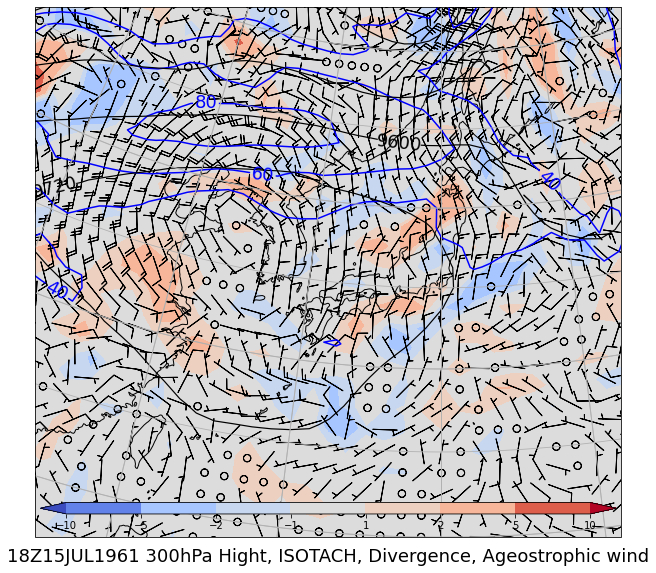

In [91]:
## 図法指定                                                                             
proj = ccrs.Stereographic(central_latitude=60, central_longitude=140)
latlon_proj = ccrs.PlateCarree()
## 図のSIZE指定inch                                                                        
fig = plt.figure(figsize=(10,8))
## 図に関する設定                                                          
plt.rcParams["contour.negative_linestyle"] = 'solid'
## 余白設定                                                                                
plt.subplots_adjust(left=0, right=1, bottom=0.06, top=0.98)                  
## 作図                                                                                    
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(i_area, latlon_proj)
#
## 海岸線
ax.coastlines(resolution='50m',) # 海岸線の解像度を上げる                                                    
ax.gridlines()
#
## グリッド線                                                                                                 
xticks=np.arange(0,360.1,dlon)
yticks=np.arange(-90,90.1,dlat)
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)
gl.ylocator = mticker.FixedLocator(yticks)
#
## 発散 
cn_reld = ax.contourf(dataReld.lon, dataReld.lat, dataReld.values * 1e5,
                    levels_reld , cmap="coolwarm", extend='both',
                    transform=latlon_proj )
# colorbarの位置と大きさ指定                                               
#  add_axes([左端の距離, 下端からの距離, 横幅, 縦幅])                      
ax_reld = fig.add_axes([0.1, 0.1, 0.8, 0.02])
cb_reld = fig.colorbar(cn_reld, orientation='horizontal', shrink=0.74,
                       aspect=40, pad=0.01, cax=ax_reld)
#
## ISOTAC 等値線                                                                  
cn_ws = ax.contour(dataWS.lon, dataWS.lat, dataWS.values,
                    colors='blue', linewidths=1.5,
                    levels=levels_ws, transform=latlon_proj )
ax.clabel(cn_ws, fontsize=18, inline=True, colors='blue',
          inline_spacing=5, fmt='%i', rightside_up=True)
#
## 等高度線 黒実線: 等値線の間隔を指定 60/120m単位
min_hgt = int(dataHgt.min() / dd_hgt) * dd_hgt
max_hgt = dataHgt.max() + dd_hgt
levels_hgt =np.arange(min_hgt, max_hgt, dd_hgt)
cn_hgt = ax.contour(dataHgt.lon, dataHgt.lat, dataHgt, colors='black',
                    linewidths=1.2, levels=levels_hgt, transform=latlon_proj )
ax.clabel(cn_hgt, levels_hgt, fontsize=18, inline=True, colors='black',
          inline_spacing=5, fmt='%i', rightside_up=True)
#
## 風 矢羽:データを間引いて描画                                            
wind_slice2 = (slice(None, None, 1), slice(None, None, 1))
wind_slice0 = slice(None, None, 1)          
ax.barbs(uag.lon[wind_slice0], uag.lat[wind_slice0],
         uag.values[wind_slice2], vag.values[wind_slice2], length=7.0,
         pivot='middle', color='black', transform=latlon_proj)
#
## 図の説明
fig.text(0.5,0.01,dt_str+" {0}hPa Hight, ISOTACH, Divergence, Ageostrophic wind".format(i_pre),
         ha='center',va='bottom', size=18)
plt.show()

In [6]:
import datetime
from dateutil import tz
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
# import metpy.calc as mpcalc
# import metpy.constants as m_const
# from metpy.units import units
import numpy as np
import xarray as xr
import scipy.ndimage as ndimage
import scipy.constants as s_const
import sys
import math
#
## 読み込みデータの指定
# JRA55の読み込む年月日時をUTCで与えます。
i_year =1961
i_month = 7
i_day = 15
i_hourZ = 18
# 気圧面を指定
i_pre=300
# データ切り出し領域
lat_cut=slice(80.0,-20.0)
lon_cut=slice(70.0,190.0)
# データ格納先フォルダー名
DataFd="./data/Jra55/"
#
## データ読み込み、データセット作成
# 年月の6桁の整数(文字列)の取得                                      
yyyymm='{:04d}{:02d}'.format(i_year,i_month)
#
## 月別のNetCDF File名
# 高度
HgtFn ='{}HGT_{}.nc'.format(DataFd,yyyymm)
#
## 高度                                                                    
ds = xr.open_dataset('HGT_196107.nc')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Call and read the downloaded data
# ds: dataset
ds = xr.open_dataset("HGT_196107.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 145, level: 37, lon: 288, time: 124)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * lat      (lat) float32 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) datetime64[ns] 1961-07-01 ... 1961-07-31T18:00:00
Data variables:
    HGT      (time, level, lat, lon) float32 ...
Attributes:
    history:      2016-12-09 21:45:52 JST root> jra55_grib2nc.rb wrote HGT
    title:        The Japanese 55-year Reanalysis (JRA-55)
    institution:  The Japan Meteorological Agency (JMA)
    comment:      These data were converted from GRIB format data provided by...
    references:   JRA-55; http://jra.kishou.go.jp/JRA-55/index_en.html,\nGPhy...

(array([592609., 231997., 230209., 122350.,  82605.,  48006.,  81269.,
         59001.,  62983.,  34091.]),
 array([ -488.2207,  4534.642 ,  9557.505 , 14580.367 , 19603.23  ,
        24626.094 , 29648.955 , 34671.816 , 39694.68  , 44717.543 ,
        49740.406 ], dtype=float32),
 <BarContainer object of 10 artists>)

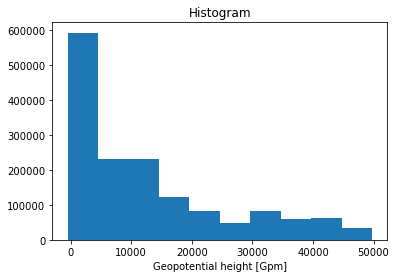

In [14]:
ds.HGT.isel(time=100).plot()

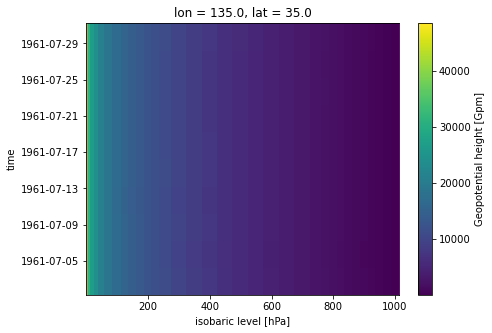

In [8]:
ds.HGT.sel(lon=135, lat=35)[7::12].plot(figsize=[7,5])
plt.show()

<a list of 11 text.Text objects>

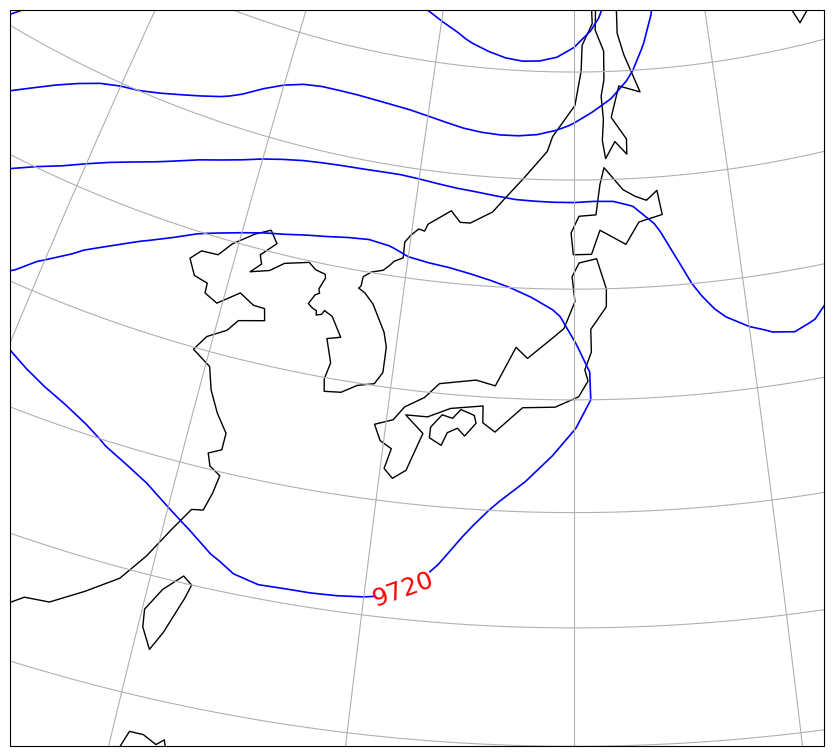

In [3]:
import datetime
from dateutil import tz
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.constants as m_const
from metpy.units import units
import numpy as np
import xarray as xr
import scipy.ndimage as ndimage
import scipy.constants as s_const
import sys
import math

i_year =1961
i_month = 7
i_day = 15
i_hourZ = 18
i_pre=300

lat_cut=slice(80.0,-20.0)
lon_cut=slice(70.0,190.0)

DataFd=""                                   
yyyymm='{:04d}{:02d}'.format(i_year,i_month)
HgtFn ='{}HGT_{}.nc'.format(DataFd,yyyymm)
                                                                   
ds = xr.open_dataset(HgtFn)

dataHgt = ds.HGT.squeeze()
time_targ=(i_day - 1) * 4 + i_hourZ//6
dataHgt = dataHgt.isel(time=time_targ)
dataHgt = dataHgt.sel(level=i_pre,lat=lat_cut, lon=lon_cut)
dataHgt.attrs['units'] = 'meter'


# ## 時刻文字列化                                  
# UTC = tz.gettz("UTC")
# dt1 = datetime.datetime.fromtimestamp(dataHgt.time.astype(datetime.datetime)*1e-9, tz=UTC)
# dt_str = (dt1.strftime("%HZ%d%b%Y")).upper()
# dt_str2 = dt1.strftime("%Y%m%d%H")
# print(dt_str)
# print(dt_str2)

proj = ccrs.Stereographic(central_latitude=60, central_longitude=140)
latlon_proj = ccrs.PlateCarree()
                                                                     
fig = plt.figure(figsize=(10,8))                                           
plt.rcParams["contour.negative_linestyle"] = 'solid'                                           
plt.subplots_adjust(left=0, right=1, bottom=0.06, top=0.98)                                                                                                  
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(i_area, latlon_proj)
ax.coastlines(resolution='110m',)                                           
ax.gridlines()

min_hgt = int(dataHgt.min() / dd_hgt) * dd_hgt
max_hgt = dataHgt.max() + dd_hgt
levels_hgt =np.arange(min_hgt, max_hgt, dd_hgt)
cn_hgt = ax.contour(dataHgt.lon, dataHgt.lat, dataHgt, colors='blue',linewidths=1.2, levels=levels_hgt, transform=latlon_proj )
ax.clabel(cn_hgt, levels_hgt, fontsize=18, inline=True, colors='red',inline_spacing=5, fmt='%i', rightside_up=True)

In [11]:
# ug,  vg  = mpcalc.geostrophic_wind(dataHgt)       


UgrdFn = "UGRD_196107.nc"
VgrdFn = "VGRD_196107.nc"
ReldFn = "RELD_196107.nc"

                                                                 
ds = xr.open_dataset(UgrdFn)
dataUgrd = ds.UGRD.squeeze()

#
dataUgrd.attrs['units'] = 'm/s'
# 利用するデータのみ切り出す                                               
dataUgrd = dataUgrd.isel(time=time_targ)
dataUgrd = dataUgrd.sel(level=i_pre,
                        lat=lat_cut,
                        lon=lon_cut)
## Wind V                                                                  
ds = xr.open_dataset(VgrdFn)
dataVgrd = ds.metpy.parse_cf('VGRD').squeeze()
dataVgrd.attrs['units'] = 'm/s'
dataVgrd = dataVgrd.isel(time=time_targ)
dataVgrd = dataVgrd.sel(level=i_pre,
                        lat=lat_cut,
                        lon=lon_cut)
## 高度                                                                    
ds = xr.open_dataset(HgtFn)
dataHgt = ds.metpy.parse_cf('HGT').squeeze()
dataHgt.attrs['units'] = 'meter'
dataHgt = dataHgt.isel(time=time_targ)
dataHgt = dataHgt.sel(level=i_pre,
                        lat=lat_cut,
                        lon=lon_cut)
## 発散                                                                    
ds = xr.open_dataset(ReldFn)
dataReld= ds.metpy.parse_cf('RELD').squeeze()
dataReld.attrs['units'] = '1 / second'                                              
dataReld = dataReld.isel(time=time_targ)
dataReld = dataReld.sel(level=i_pre,
                        lat=lat_cut,
                        lon=lon_cut)

In [13]:
# ug,  vg  = mpcalc.geostrophic_wind(dataHgt)                               
# 非地衡風 m/s => knot                                                     
uag, vag = mpcalc.ageostrophic_wind(dataHgt, dataUgrd, dataVgrd)
uag = uag * 1.944
vag = vag * 1.944
# 風速 m/s => knot                                                         
dataWS = mpcalc.wind_speed(dataUgrd, dataVgrd)
dataWS = dataWS * 1.944

CRSError: Invalid datum string: urn:ogc:def:datum:EPSG::6326: (Internal Proj Error: proj_create: no database context specified)